<a href="https://colab.research.google.com/github/DoMoOrt/PruebaNLP/blob/main/prueba_tecnicaDomenicoMorales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prueba Técnica para Python AI

Se presenta la prueba técnica donde se realiza un modelo para obtener el tema de algún artículo y sus palabras más frecuentes.

## Importar las librerías necesarias
De no estar instaladas algunas, ejecute:

```
!pip install [nombre de la librerias]
```


In [ ]:
import csv
import pprint
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku
from colour import Color
from operator import itemgetter
from urllib.request import urlopen
from nltk.stem import PorterStemmer
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Dropout, GlobalAveragePooling1D, LSTM, Conv1D, Bidirectional

## Obtener las palabras más comunes

###Obtener los datos directamente del URL

Se utiliza el formato html para poder extraer únicamente el cuerpo del artículo con el nombre de la clase.

```
<div class= Nombre_de_la_clase_del_articulo>
  Texto del artículo
</div>
```


In [ ]:
#@markdown Seleccione el artículo a analizar
from bs4 import BeautifulSoup

Artículo = "Tarjetas Graficas"  #@param ['Criptomonedas', 'Tarjetas Graficas', 'Python']

if Artículo == "Criptomonedas":
  URL = "https://www.consumidor.ftc.gov/articulos/lo-que-hay-que-saber-sobre-las-criptomonedas"
  Art = "field field-name-body field-type-text-with-summary field-label-hidden"
elif Artículo == "Tarjetas Graficas":
  URL = "https://www.nitro-pc.es/blog/escasez-de-tarjetas-graficas/"
  Art = "content-post"
elif Artículo == "Python":
  URL = "https://desarrolloweb.com/articulos/1325.php"
  Art = "Article-content"

soup = BeautifulSoup(urlopen(URL).read(), 'lxml')

for link in soup.find_all('title'):
  print("Título del artículo: {}".format(link.text))

f = open("raw_html.txt","w+")

for link in soup.find_all('div', class_= Art):
  #print(link.text)
  f.write(link.text)

f.close()

Título del artículo: ¿Por qué no hay tarjetas gráficas Nvidia y AMD? ¿Hasta cuándo durará?


###Preprocesar los datos del archivo creado
Primero, es necesario eliminar las líneas en blanco y limpiar el texto.

In [ ]:
#@markdown Archivo data.txt
mostrar_Texto = True #@param {type:"boolean"}
sentences = []
with open('raw_html.txt', 'r') as inFile, open('data.txt', 'w+') as outFile:
    for line in inFile:
      if line.strip():
        outFile.write(line.lower())
        sentences.append(line.lower().strip())

print("Se creó el archivo 'raw_html.txt': texto directo del artículo")
print("Se creó el archivo 'data.txt': texto sin líneas en blanco ni espacios de más")

with open("data.txt", "r") as inFile, open('oneLine.txt', 'w') as outFile:
  for line in inFile:
    outFile.write(''.join(line.rstrip()))
    sentences.append(line)

print("Se creó el archivo 'oneLin.txt': texto limpio en una sola línea para predicción")

if mostrar_Texto:
  f = open('data.txt', 'r')
  print(f.read())
  f.close()

print("\nOraciones en total: {}".format(len(sentences)))

Se creó el archivo 'raw_html.txt': texto directo del artículo
Se creó el archivo 'data.txt': texto sin líneas en blanco ni espacios de más
Se creó el archivo 'oneLin.txt': texto limpio en una sola línea para predicción
¡hola a todos nitroamig@s! hoy vamos a tratar un tema muy necesario y por el cual muchas personas y empresas se están viendo afectadas. hablaremos y responderemos las preguntas acerca de la escasez de tarjetas gráficas. ¿por qué no hay tarjetas gráficas nvidia y amd? ¿hasta cuándo durará? vayamos al grano porque es ya un tema bastante serio.la cosa no pinta bienno es solo algo puntual como en otras ocasiones. no se trata de un par de semanas o tres de mala o baja producción (o de la ya clásica depredación masiva por parte de los criptomineros) en las que rápidamente todo vuelve a la normalidad. esto es algo que lleva ocurriendo desde primeros de noviembre, y más de dos meses después, camino de tres, la cosa no solo no ha mejorado, sino que empeora cada día.actualmente de

Se eliminan palabras como artículos y preposiciones usando Stopwords, así como signos de puntuación y caracteres especiales.

Se usó *Stemming* para poder agrupar las palabras encontradas.

In [ ]:
#@markdown Comparación de datos
stop_words = {'seamos', 'cómo', 'estuviste', 'pueden', 'puede', 'unos', 'habido', 'y', 'o', 'u', 'a', 'tendrías', 'serías', 'muy', 'estados', 'éramos', 'está', 'fueron', 'que', 'estoy', 'estar', 'tuvieses', 'tengan', 'tendríamos', 'tendrías', 'hubieron', 'tienen', 'sus', 'mí', 'hubieses', 'estuviese', 'estabas', 'fueran', 'este', 'mucho', 'tuyos', 'esté', 'estén', 'todos', 'e', 'contra', 'habré', 'sentidos', 'tengan', 'todo', 'tendrás', 'tuvieras', 'por', 'tuviesen', 'tengas', 'será', 'o', 'mi', 'tened', 'tengamos', 'no', 'habrían', 'tendré', 'erais', 'habidos', 'tenían', 'hayan', 'teniendo', 'os', 'sus', 'más', 'fuerais', 'nada', 'ya', 'habidas', 'son', 'seremos', 'tenías', 'haya', 'esas', 'míos', 'tendrían', 'estuviéramos', 'estuvieses', 'un', 'tenía', 'estuvieseis', 'estuvieron', 'se', 'serás', 'me', 'estuvieras', 'tuviste', 'estabas', 'tanto', 'algo', 'donde', 'la', 'como', 'hubiste', 'eres', 'fue', 'suyo', 'eso', 'uno', 'el', 'tendrías', 'tuve', 'para', 'habríass', 'él', 'vosotros', 'hayamos', 'en', 'tuyas', 'tus', 'sintiendo', 'sean', 'habían', 'tuviésemos', 'quien', 'qué', 'sin', 'entre', 'te', 'tu', 'tuvieron', 'tenidas', 'sentidas', 'tenías', 'suya', 'fuesen', 'tendría', 'nuestra', 'otros', 'muchos', 'tienes', 'al', 'estado', 'había', 'a', 'con', 'habríamos', 'somos', 'tiene', 'porque', 'les', 'nosotras', 'cuando', 'hay', 'tenida', 'estés', 'sería', 'tenido', 'ti', 'fuese', 'habida', 'otras', 'vuestro', 'habías', 'fuésemos', 'hayáis', 'estuviera', 'seréis', 'tendrán', 'mías', 'estamos', 'es', 'hubimos', 'habíais', 'tuvieseis', 'ellas', 'pero', 'estuviésemos', 'tenéis', 'habremos', 'hube', 'tenidos', 'habríais', 'ha', 'estaría', 'teníamos', 'tuyo', 'ese', 'fui', 'eran', 'una', 'ante', 'estaremos', 'hayas', 'estarás', 'esos', 'hubiese', 'tuvieras', 'estada', 'hasta', 'tendrá', 'sentid', 'poco', 'fuisteis', 'tú', 'estuvieran', 'sentida', 'otra', 'estadas', 'habrías', 'he', 'seáis', 'su', 'estábamos', 'hubiésemos', 'mis', 'tuviese', 'habiendo', 'estaríais', 'estando', 'vosotras', 'tuviera', 'esto', 'estuviesen', 'mío', 'también', 'yo', 'siente', 'hubiera', 'otro', 'estarán', 'sea', 'nuestras', 'vuestros', 'nosotros', 'estáis', 'ellos', 'antes', 'hubieran', 'soy', 'del', 'has', 'seré', 'tuvimos', 'han', 'nos', 'era', 'seríais', 'suyos', 'nuestros', 'estuvimos', 'algunas', 'estuvierais', 'vuestra', 'hubieras', 'sois', 'lo', 'nuestro', 'estarías', 'esta', 'estuviste', 'sobre', 'tengo', 'seríamos', 'fuimos', 'esa', 'estuve', 'tenemos', 'estaréis', 'sí', 'hubieses', 'estás', 'estaba', 'hubierais', 'mía', 'fueras', 'tuviéramos', 'estos', 'estemos', 'fuiste', 'tuvisteis', 'seas', 'habrá', 'hubiéramos', 'tuvo', 'hubisteis', 'estaré', 'le', 'estarían', 'los', 'las', 'serán', 'ella', 'quienes', 'desde', 'tuvieran', 'hemos', 'cual', 'tenga', 'ni', 'estad', 'durante', 'algunos', 'habrás', 'están', 'suyas', 'habéis', 'fuera', 'estuvo', 'tuya', 'estaban', 'de', 'estén', 'eras', 'hubo', 'habíamos', 'fueses', 'estas', 'habrán', 'tendremos', 'sentido', 'estará', 'estaríamos', 'habría', 'fueseis', 'serían', 'hubiesen', 'fuéramos', 'a', 'ante', 'bajo', 'cabe', 'con', 'contra', 'de', 'desde', 'durante', 'en', 'entre', 'hacia', 'hasta', 'mediante', 'para', 'por', 'según', 'sin', 'so', 'sobre', 'tras', 'versus', 'vía', 'el', 'la', 'los', 'las', 'si'}
f_sentences = []
stem_sentences = []
for sentence in sentences:
  for word in stop_words:
    token = " " + word + " "
    sentence = sentence.replace(token, " ")
    sentence = sentence.replace(",", "")
    sentence = sentence.replace(".", "")
    sentence = sentence.replace("—", "")
    sentence = sentence.replace("|", "")
    sentence = sentence.replace("¿", "")
    sentence = sentence.replace("?", "")
    sentence = sentence.replace("'", "")
    sentence = sentence.replace("¡", "")
    sentence = sentence.replace("!", "")
    sentence = sentence.replace("@", "")
  f_sentences.append(sentence)

ps = PorterStemmer()
for sentence in f_sentences:
  for word in sentence.split(" "):
    s_word = ps.stem(word.strip())
    sentence = sentence.replace(word, s_word)
  stem_sentences.append(sentence.strip())

sentence_index = 1 #@param {type:"integer"}
mostrar_Oracion = True #@param {type:"boolean"}
mostrar_Oracion_Stopwords = True #@param {type:"boolean"}
mostrar_Oracion_Stemming = True #@param {type:"boolean"}
print("Oración: {}".format(sentences[sentence_index]))
print("Oración después de stopwords: {}".format(f_sentences[sentence_index]))
print("Oración después de Stemming: {}".format(stem_sentences[sentence_index]))

Oración: ¡hola a todos nitroamig@s! hoy vamos a tratar un tema muy necesario y por el cual muchas personas y empresas se están viendo afectadas. hablaremos y responderemos las preguntas acerca de la escasez de tarjetas gráficas. ¿por qué no hay tarjetas gráficas nvidia y amd? ¿hasta cuándo durará? vayamos al grano porque es ya un tema bastante serio.la cosa no pinta bienno es solo algo puntual como en otras ocasiones. no se trata de un par de semanas o tres de mala o baja producción (o de la ya clásica depredación masiva por parte de los criptomineros) en las que rápidamente todo vuelve a la normalidad. esto es algo que lleva ocurriendo desde primeros de noviembre, y más de dos meses después, camino de tres, la cosa no solo no ha mejorado, sino que empeora cada día.actualmente decenas de empresas que se dedicaban parcial o totalmente a la venta de ordenadores, han tenido que dejar de hacerlo. tan solo unas pocas en toda europa, (entre las que se encuentra nitropc) siguen pudiendo recog

### Tokenizar
Se utlizan *Tokens* para convertir las palabras a números y poder analizarlos.

Este proceso es el siguiente: Crear token -> tokenizar

In [ ]:
#@title 
tokenizer_words = Tokenizer()
tokenizer_words.fit_on_texts(stem_sentences)
total_words = len(tokenizer_words.word_index) + 1
print("Total de palabras encontradas: {}".format(total_words))

mostrar_Dict = False #@param {type:"boolean"}
if mostrar_Dict:
  print("Diccionario de palabras:")
  pprint.pprint(tokenizer_words.word_index)

Total de palabras encontradas: 402


### Visualizar los datos obtenidos
Mostrar las 5 palabras más usadas en una gráficas de barras

{'gráfica': 22, 'tarjeta': 14, 'amd': 14, 'nvidia': 12, 'cosa': 10}



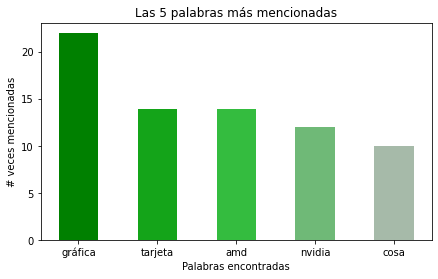

In [ ]:
num_words = 5 #@param {type:"slider", min: 1, max: 25}
top = dict(sorted(tokenizer_words.word_counts.items(), key = itemgetter(1), reverse = True)[:num_words])
print(top)
print()
plt.figure(figsize= (num_words+2, 4))
green = Color("green")
colors = list(green.range_to(Color("#a6baa9"), num_words))
colors = [color.rgb for color in colors]
plt.ylabel('# veces mencionadas')
plt.xlabel('Palabras encontradas')
plt.title(f"Las {num_words} palabras más mencionadas")
plt.bar(top.keys(), top.values(), width=0.5, color= colors)
plt.show()

Mostrar las palabras en un WordCloud donde, mientras más se usen, más grande será la fuente

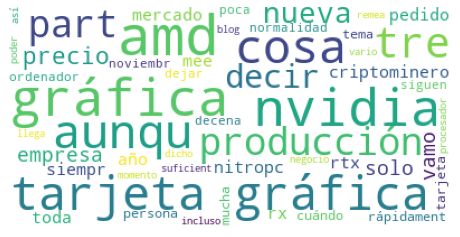

In [ ]:
num_words = 50 #@param {type:"slider", min: 1, max: 100}
wordcloud = WordCloud(background_color='white',
                      stopwords=stop_words,
                      max_words=num_words,
                      max_font_size=50, 
                      random_state=42
                      ).generate(str(stem_sentences))

plt.figure(figsize= (8, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Predecir el tópico del artículo

### Obtener datos de Google Sheets

La base de datos, proporcionada por BBC, contiene artículos limpios y lemmetizados. Se creó una Sheet en Google Drive para poder traducirlo directamente.

In [ ]:
#@markdown Se tiene que atenticar el acceso a Google Cloud SDK para poder acceder al Google Sheet
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1UPIwBJ3Opwxm3OwQHTDz9uH6fRn5Wn4qkjq5PHGqSUY/edit?usp=sharing').worksheet("bbc-text-español")

rows = worksheet.get_all_values()

bbc_df = pd.DataFrame.from_records(rows, columns= ["Category", "Words"])
bbc_df = bbc_df.iloc[1:]
bbc_df

,Category,Words
1,tecnología,futura televisión en las manos de los espectad...
2,negocio,"WorldCom jefe dejó solos libros antiguos, Bern..."
3,deporte,tigres cuidadoso de apuesta Farrell Leicester ...
4,deporte,Yeading cara de Newcastle en fa lado taza del ...
5,entretenimiento,océano s doce incursiones Taquilla océano s se...
...,...,...
2221,negocio,coches tiran hacia abajo nos figuras minorista...
2222,política,Revela Kilroy política de inmigración ex chats...
2223,entretenimiento,REM anuncia nuevo concierto Glasgow grupo esta...
2224,política,Cómo disputas políticas bola de nieve que s un...


WARNING: Es necesario que en la tabla anterior se vean todos los datos, de no ser así, esperar unos segundos y volver a correr la celda.

In [ ]:
sentences = []
labels = []

for row in range(len(bbc_df)):
  labels.append(bbc_df['Category'].values[row])
  sentence = bbc_df['Words'].values[row]
  for word in stop_words:
    token = " " + word + " "
    sentence = sentence.replace(token, " ")
    s_word = ps.stem(word.strip())
    sentence = sentence.replace(word, s_word)
  sentences.append(sentence.strip())

sentence_index = 6 #@param {type:"slider", min:0, max:100, step:1}

print(f"En esta base de datos hay un total de {len(sentences)} oraciones de {len(np.unique(labels))} diferentes tópicos\n")
print(f"La oración con índice {sentence_index}: {sentences[sentence_index]}")
print(f"Con el tópico de: {str(labels[sentence_index]).upper()}")

En esta base de datos hay un total de 2225 oraciones de 5 diferentes tópicos

La oración con índice 6: Blair prepara nombrar fecha sondeo, Tony Blair, probable nombre 5 mayo día elección rendimientos parlamento receso Pascua editor político BBC s aprendido. Andrew Marr dice Blair pedirá reina, 4 5 abril disolver Parlamento final semana. Blair resistido ahora llamadas nombrar día, todas partes intensificado campañas recientemente. calle derribo dibuja reclamo diciendo momento electoral cuestión primer ministro. portavoz número 10 limitó decir: anunciará elección quiere anunciar elección. medida señal semana frenética Westminster gobierno probable trate obtener legislación clave través parlamento. gobierno ley presupuesto cubren planes presupuesto aprobó ants cierre Commons negocios final sesión, 7 abril. tratará empujar través grave organizada ley crimen tarjetas identificación factura. Sr. Marr dijo programa hoy Miércole s: s casi nadie alto nivel gobierno propio parlamento doesn t esp

### Tokenizar y crear secuencias

In [ ]:
#@markdown Se usa el procedimiento anterior más la creación de secuencias y padding. Esto es necesario para poder analizar las oraciones completas.

#@markdown Crear token -> tokenizar -> crear secuencias -> crear padding
max_length = None
vocab_size = 1000
oov_tok = "<OOV>"
padding_type='pre'
train_factor = 0.9

train_size = int(len(sentences) * train_factor)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(f"Se divide la base de datos en {int(train_factor*100)}% para el entrenamiento y {round((1-train_factor)*100)}% para la validación.")
print(f"Esto resulta en {len(train_sentences)} oraciones para entrenamiento y {len(validation_sentences)} oraciones para la validación.")
print(f"Hay un total de {len(word_index)} palabras encontradas.")
print(f"El diccionario de tópicos es: {label_tokenizer.word_index}")

Se divide la base de datos en 90% para el entrenamiento y 10% para la validación.
Esto resulta en 2002 oraciones para entrenamiento y 223 oraciones para la validación.
Hay un total de 33491 palabras encontradas.
El diccionario de tópicos es: {'deporte': 1, 'negocio': 2, 'política': 3, 'tecnología': 4, 'entretenimiento': 5}


### Crear el modelo

In [ ]:
#@markdown Se crea el modelo utilizando una Embedding layer como Input

#@markdown Se utiliza una activación softmax en la última layer para poder obtener la probabilidad de cada clase
model = tf.keras.Sequential([
    Embedding(1000, 16, input_length= max_length),
    GlobalAveragePooling1D(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(24, activation='relu'),
    Dropout(0.1),
    Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_58 (Embedding)     (None, None, 16)          16000     
_________________________________________________________________
global_average_pooling1d_57  (None, 16)                0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_135 (Dense)            (None, 32)                544       
_________________________________________________________________
dropout_74 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_136 (Dense)            (None, 24)                792       
_________________________________________________________________
dropout_75 (Dropout)         (None, 24)              

In [ ]:
#@markdown Entrenar el modelo
epochs =   100#@param {type: "integer"}
history = model.fit(train_padded, training_label_seq, validation_data=(validation_padded, validation_label_seq), epochs= epochs, verbose=1)
model.save('topic_Pred_Model.h5')
print("Modelo guardado como 'topic_Pred_Model.h5'")

Epoch 1/100
63/63 [==============================] - 1s 10ms/step - loss: 1.7803 - accuracy: 0.1808 - val_loss: 1.7150 - val_accuracy: 0.2377
Epoch 2/100
63/63 [==============================] - 0s 7ms/step - loss: 1.6911 - accuracy: 0.2298 - val_loss: 1.6287 - val_accuracy: 0.2377
Epoch 3/100
63/63 [==============================] - 0s 8ms/step - loss: 1.6336 - accuracy: 0.2353 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 4/100
63/63 [==============================] - 0s 7ms/step - loss: 1.6189 - accuracy: 0.2205 - val_loss: 1.6033 - val_accuracy: 0.1928
Epoch 5/100
63/63 [==============================] - 0s 8ms/step - loss: 1.6158 - accuracy: 0.2447 - val_loss: 1.6029 - val_accuracy: 0.1928
Epoch 6/100
63/63 [==============================] - 0s 7ms/step - loss: 1.6142 - accuracy: 0.2250 - val_loss: 1.5889 - val_accuracy: 0.2780
Epoch 7/100
63/63 [==============================] - 0s 8ms/step - loss: 1.6042 - accuracy: 0.2318 - val_loss: 1.5789 - val_accuracy: 0.3049
Epoch 8/100


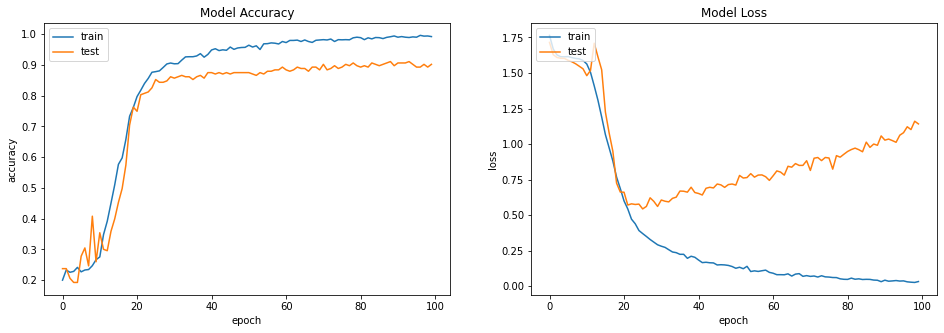


7/7 [==============================] - 0s 2ms/step - loss: 1.1419 - accuracy: 0.9013


[1.141905426979065, 0.9013453125953674]

In [ ]:
#@markdown Observamos gráficas del rendimiento del modelo
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize= (16,5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print()
model.evaluate(validation_padded, validation_label_seq)

Siendo un modelo que utiliza oraciones para predecir, es dificil eliminar el *overfitting*, sin embargo, se logró una precisión del 90%. Al ser una base de datos "pequeña" no fue necesaria una red más compleja.

### Predicción

In [ ]:
#@markdown Se hace el mismo proceso de Tokenizar y crear secuencias para poder predecir el texto del artículo desde el archivo oneLine.txt

tf.get_logger().setLevel('ERROR')

trained_model = tf.keras.models.load_model('topic_Pred_Model.h5')

test =[]
with open("oneLine.txt","r") as input:
  for line in input:
    test.append(line)

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(test)
test_sequences = tokenizer.texts_to_sequences(test)
test_padded = pad_sequences(test_sequences, padding=padding_type)

prediction_index = trained_model.predict(test_padded)
print("Probabilidades obtenidas por el modelo: {}".format(prediction_index[0][1:]))
top1= np.argmax(prediction_index, axis= 1)
prediction_index[0][top1] = 0
top2 = np.argmax(prediction_index, axis= 1)

key_list = list(label_tokenizer.word_index.keys())
val_list = list(label_tokenizer.word_index.values())
position1 = val_list.index(top1)
position2 = val_list.index(top2)
print("Los indices predecidos son: {} y {}".format(top1, top2))
print(f"Se predijo que este artículo podría tratarse de {str(key_list[position1]).upper()} y/o {str(key_list[position2]).upper()}")

Probabilidades obtenidas por el modelo: [0.0000000e+00 4.0902646e-09 4.2958996e-05 9.9995708e-01 3.5295873e-28]
Los indices predecidos son: [4] y [3]
Se predijo que este artículo podría tratarse de TECNOLOGÍA y/o POLÍTICA


El modelo puede ser mejorado al añadir datos para el entrenamiento. Asimismo, la predicción podría reducirse a pequeñas oraciones para así poder tener una predicción más certera. 